In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import squarify
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

## Loading the data 

In [2]:
df=pd.read_csv("../input/netflix-shows/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
df.describe(include = [np.object]).T.style.set_properties(**{'background-color':'white',
                                     'color': 'black',
                                      'border-color':'black' })

,count,unique,top,freq
show_id,8807,8807,s1,1
type,8807,2,Movie,6131
title,8807,8807,Dick Johnson Is Dead,1
director,6173,4528,Rajiv Chilaka,19
cast,7982,7692,David Attenborough,19
country,7976,748,United States,2818
date_added,8797,1767,"January 1, 2020",109
rating,8803,17,TV-MA,3207
duration,8804,220,1 Season,1793
listed_in,8807,514,"Dramas, International Movies",362


In [5]:
df.describe(include = [np.number]).T.style.set_properties(**{'background-color':'white',
                                     'color': 'black',
                                      'border-color':'black'})

,count,mean,std,min,25%,50%,75%,max
release_year,8807.000000,2014.180198,8.819312,1925.000000,2013.000000,2017.000000,2019.000000,2021.000000


In [6]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [7]:
fill_list = df['country'].dropna().tolist()
df['country'] = df['country'].fillna(pd.Series(np.random.choice(fill_list , size = len(df.index))))

In [8]:
df['director'] = df['director'].fillna('NoDataAvailable')
df['cast'] = df['cast'].fillna('NoDataAvailable')
df['rating']=df['rating'].fillna('No Rating')

In [9]:
df['date_added']=df['date_added'].fillna(method="ffill")

In [10]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        3
listed_in       0
description     0
dtype: int64

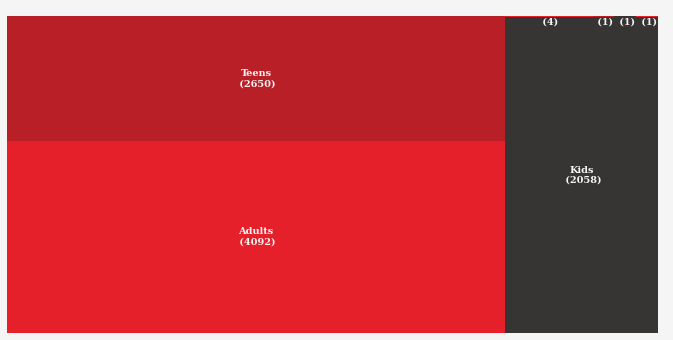

In [11]:
rating = {  'TV-Y' : 'Kids',
            'TV-Y7' : 'Kids' ,
            'TV-G'  : 'Kids',
            'PG'    : 'Kids',
            'TV-PG' : 'Kids',
            'PG-13' : 'Teens',
            'TV-14' : 'Teens',
            'R'     : 'Adults',
            'TV-MA' : 'Adults',
            'NC-17' : 'Adults',
            'NR': 'Adults',
            'UR': 'Adults',
            'TV-Y7-FV':'Kids',
            'G': 'Kids'} 

df['age_rating'] = df['rating'].replace(to_replace = rating)

age_ratings = df['age_rating'].value_counts()

labels = [ str(idx) + "\n (" + str(val) + ")" for idx, val in age_ratings.items()]

fig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')


squarify.plot(sizes= age_ratings.values, label = labels,
              color = ['#e50914', '#b20710','#221f1f'],
              ax = ax, text_kwargs = {'font':'serif', 'color': '#f6f5f5', 'weight':'bold'},
              alpha = 0.9)

ax.axis('off')
fig.show()


In [12]:
pd.to_datetime(df['date_added'])

0      2021-09-25
1      2021-09-24
2      2021-09-24
3      2021-09-24
4      2021-09-24
          ...    
8802   2019-11-20
8803   2019-07-01
8804   2019-11-01
8805   2020-01-11
8806   2019-03-02
Name: date_added, Length: 8807, dtype: datetime64[ns]

In [13]:
df['date_added']=pd.to_datetime(df['date_added'])

In [14]:
df.groupby("date_added")[["show_id"]].count()

,show_id
date_added,
2008-01-01,1
2008-02-04,1
2009-05-05,1
2009-11-18,1
2010-11-01,1
...,...
2021-09-21,5
2021-09-22,9
2021-09-23,2


In [15]:
shows_added = df.groupby("date_added")[["show_id"]].count()
shows_added =shows_added.rename({"show_id" : "Number_of_shows_added"} , axis = 1)
shows_added

,Number_of_shows_added
date_added,
2008-01-01,1
2008-02-04,1
2009-05-05,1
2009-11-18,1
2010-11-01,1
...,...
2021-09-21,5
2021-09-22,9
2021-09-23,2


In [16]:
shows_added.reset_index

<bound method DataFrame.reset_index of             Number_of_shows_added
date_added                       
2008-01-01                      1
2008-02-04                      1
2009-05-05                      1
2009-11-18                      1
2010-11-01                      1
...                           ...
2021-09-21                      5
2021-09-22                      9
2021-09-23                      2
2021-09-24                     10
2021-09-25                      1

[1714 rows x 1 columns]>

<AxesSubplot:xlabel='date_added'>

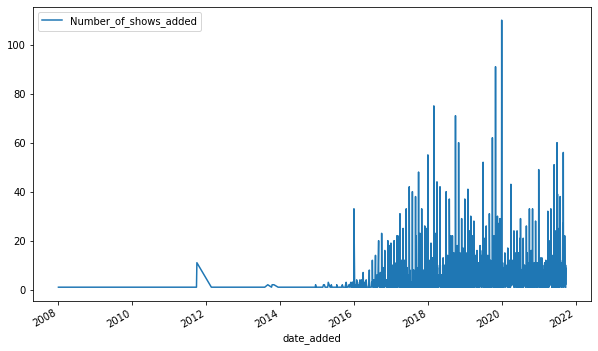

In [17]:
shows_added.plot(figsize = (10,6))

In [18]:
shows_added['day_name'] = shows_added.index.day_name()
shows_added['month_name'] = shows_added.index.month_name()
shows_added

,Number_of_shows_added,day_name,month_name
date_added,,,
2008-01-01,1,Tuesday,January
2008-02-04,1,Monday,February
2009-05-05,1,Tuesday,May
2009-11-18,1,Wednesday,November
2010-11-01,1,Monday,November
...,...,...,...
2021-09-21,5,Tuesday,September
2021-09-22,9,Wednesday,September
2021-09-23,2,Thursday,September


In [19]:
shows_added = shows_added[['Number_of_shows_added', 'day_name']]

In [20]:
shows_added = shows_added[['Number_of_shows_added', 'day_name']]

In [21]:
shows_added.groupby("day_name").count()

,Number_of_shows_added
day_name,
Friday,328
Monday,218
Saturday,215
Sunday,185
Thursday,256
Tuesday,268
Wednesday,244


In [22]:
shows_added.groupby("day_name").sum()

,Number_of_shows_added
day_name,
Friday,2499
Monday,851
Saturday,817
Sunday,753
Thursday,1396
Tuesday,1199
Wednesday,1292


In [23]:
total_per_week =shows_added.groupby("day_name")['Number_of_shows_added'].sum()
total_per_week

day_name
Friday       2499
Monday        851
Saturday      817
Sunday        753
Thursday     1396
Tuesday      1199
Wednesday    1292
Name: Number_of_shows_added, dtype: int64

<AxesSubplot:xlabel='day_name'>

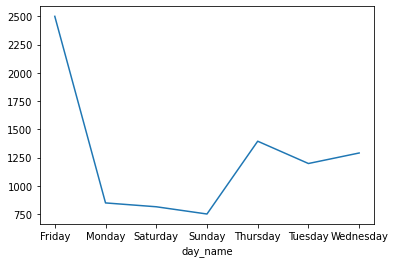

In [24]:
total_per_week.plot()

In [25]:
shows_added

,Number_of_shows_added,day_name
date_added,,
2008-01-01,1,Tuesday
2008-02-04,1,Monday
2009-05-05,1,Tuesday
2009-11-18,1,Wednesday
2010-11-01,1,Monday
...,...,...
2021-09-21,5,Tuesday
2021-09-22,9,Wednesday
2021-09-23,2,Thursday


<AxesSubplot:xlabel='date_added'>

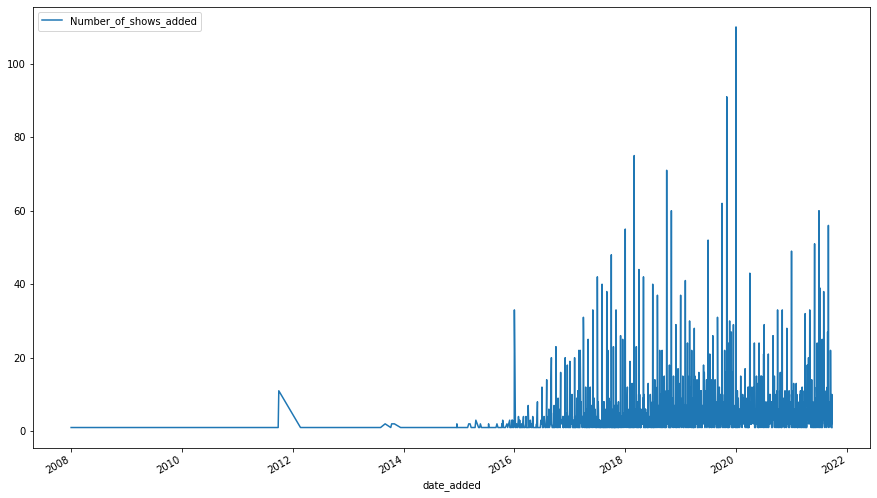

In [26]:
shows_added.plot(figsize=(15,9))

In [27]:
df['added_year'] = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month
df['added_month_name'] = df['date_added'].dt.month_name()
add_year = df['added_year'].value_counts()
release = df['release_year'].value_counts()

### which the most enterning year

In [28]:
TV = df[df['type'] == 'TV Show'].added_year.value_counts()
Movie = df[df['type'] == 'Movie'].added_year.value_counts()

Tv_df = pd.DataFrame({'year': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'year': Movie.index, 'Movie_count': Movie.values})

add_data = pd.merge(Tv_df, Movie_df, how = 'right', on = 'year')
add_data.fillna('0', inplace = True)
add_data['Tv_count'] = add_data.Tv_count.astype('int64')
add_data = add_data.sort_values('year', ascending = False).reset_index(drop = True)

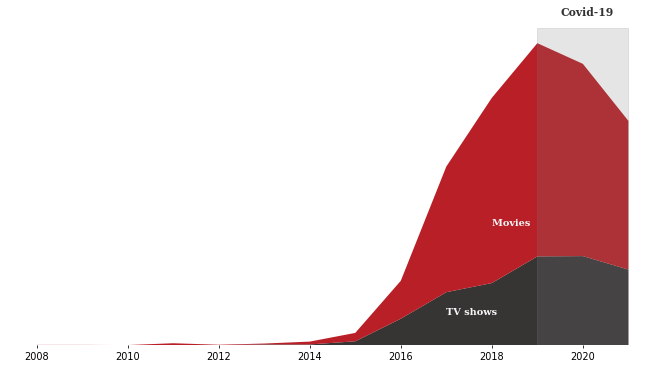

In [29]:
ig, ax = plt.subplots(figsize = (12,6), dpi = 70)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

labels = [ 'TV shows', 'Movies ']

ax.stackplot(add_data.year[0:25], add_data.Tv_count[0:25],add_data.Movie_count[0:25],labels =labels, 
              colors = ['#221f1f','#b20710',], baseline = 'zero', alpha = 0.9 )

 
ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019.5, 2200, 'Covid-19', {'font':'serif', 'fontsize': '11', 'color': 'black', 'weight':'bold'},alpha = 0.8)

ax.text(2018, 800,'{}'.format(labels[1]), {'font':'serif', 'color':'#f6f5f5', 'weight':'bold'})
ax.text(2017, 200, '{}'.format(labels[0]),{'font':'serif', 'color':'#f6f5f5','weight':'bold'}) 

plt.box(on = None)

ax.axes.get_yaxis().set_visible(False)
fig.show()

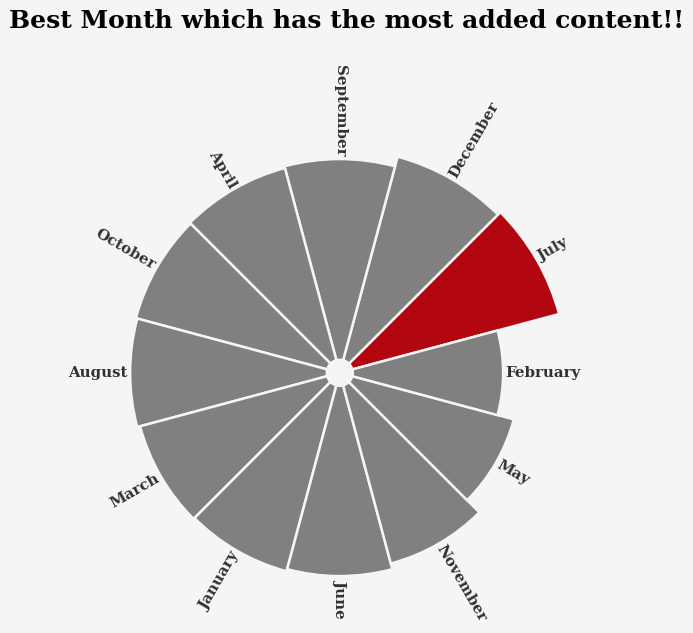

In [30]:
added_month = df['added_month'].value_counts()
fig = plt.figure(figsize=(14,7), dpi = 90)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
ax = plt.subplot(polar=True)
plt.axis('off')

label_map = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
lab = added_month.index
labels = lab.map(label_map)

colors = ['#b20710', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey','grey']

upperLimit = 1000
lowerLimit = 50
labelPadding = 10

max = added_month.max()
slope = (max - lowerLimit) / max
heights = slope * added_month.values + lowerLimit
width = 2*np.pi / len(added_month.index)
indexes = list(range(1, len(added_month)+1))
angles = [element * width for element in indexes]

bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="#f6f5f5",
    color = colors,
)

for bar, angle, height, label in zip(bars,angles, heights, labels):

    rotation = np.rad2deg(angle)
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",**{'font':'serif', 'size':12, 'weight':'bold','color':'black'},alpha = 0.8) 

fig.text(0.25,1.05,'Best Month which has the most added content!!',{'font':'serif', 'size':20, 'weight':'bold','color':'black'})
fig.show()

In [31]:
df['type'].value_counts()

Movie      6131
TV Show    2676
Name: type, dtype: int64

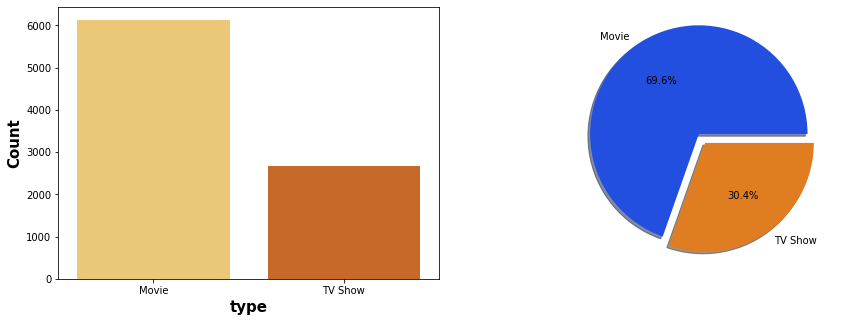

In [32]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.countplot(data = df, x = 'type', palette='YlOrBr',ax=ax[0]);
ax[0].set_xlabel("type",fontsize=15, weight='semibold')
ax[0].set_ylabel("Count",fontsize=15, weight='semibold');
y=df["type"].value_counts()
labels = ["Movie", "TV Show"] 
mycolors = ["#224FDF", "#DF7D20"] 
explode = [0.1, 0] 
plt.pie(y, labels = labels,colors=mycolors ,autopct='%1.1f%%', explode = explode, shadow= True) 
plt.show()

Text(0.5, 1.0, ' Which country has more movies ')

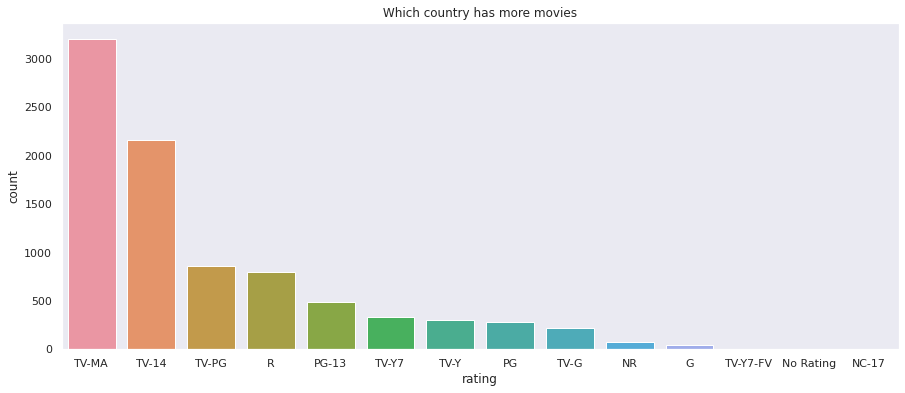

In [33]:
plt.figure(figsize=(15 ,6 ))
sns.set(style='dark')
sns.countplot(data = df , x = df['rating'] , order=df['rating'].value_counts().index[0:14])
plt.title(' Which country has more movies ') 

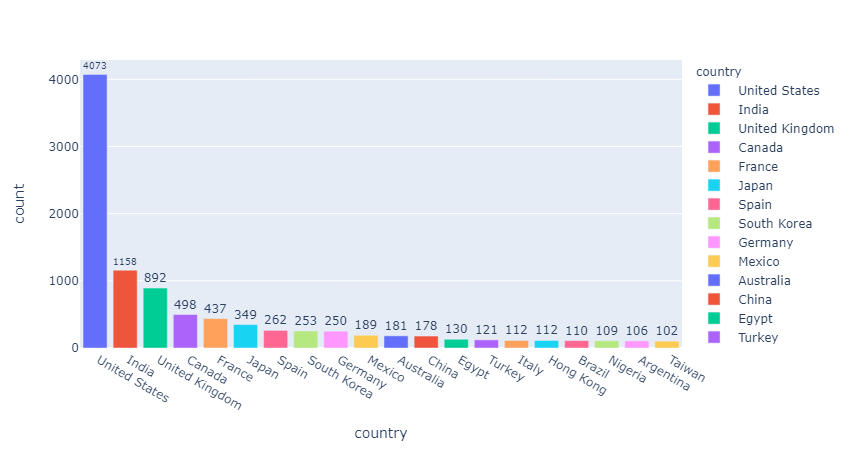

In [39]:
import re
import plotly.express as px
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot,plot,init_notebook_mode
init_notebook_mode(connected= True)

country = df[~df["country"].isnull()]['country'].to_list()

country = str(country)

country = re.sub("[\'\]\[]","",country)
country = re.sub(" {2,}", " ", country)

country = pd.Series(country.split(",")).value_counts()

country = pd.DataFrame(country)
country.reset_index(inplace=True)

country.columns=["country","count"]

fig = px.bar(country.head(20), x="country", y="count",text="count",color="country")
fig.update_traces(textposition="outside")
fig.show()

In [40]:
shows_added['added_month_name'] = shows_added.index.month_name()

In [41]:
shows_added

,Number_of_shows_added,day_name,added_month_name
date_added,,,
2008-01-01,1,Tuesday,January
2008-02-04,1,Monday,February
2009-05-05,1,Tuesday,May
2009-11-18,1,Wednesday,November
2010-11-01,1,Monday,November
...,...,...,...
2021-09-21,5,Tuesday,September
2021-09-22,9,Wednesday,September
2021-09-23,2,Thursday,September


In [42]:
df["date_added"]=pd.to_datetime(df['date_added'])
shows_added=df.groupby(pd.Grouper(key='date_added', axis=0, freq='M'))["show_id"].count()
shows_added=shows_added.to_frame()
shows_added = shows_added.rename({"show_id": "value"} , axis = 1)
shows_added

,value
date_added,
2008-01-31,1
2008-02-29,1
2008-03-31,0
2008-04-30,0
2008-05-31,0
...,...
2021-05-31,132
2021-06-30,207
2021-07-31,257


In [43]:
start_date = '2014-1-1'
mask = (shows_added.index > start_date)
shows_added=shows_added.loc[mask]
shows_added

,value
date_added,
2014-01-31,2
2014-02-28,2
2014-03-31,0
2014-04-30,2
2014-05-31,0
...,...
2021-05-31,132
2021-06-30,207
2021-07-31,257


In [44]:
def ACF_and_PACF(data):
      fig = plt.figure(figsize=(17,10))
      ax1 = fig.add_subplot(211)
      fig = plot_acf(data , lags = 30 , ax = ax1)
      ax2 = fig.add_subplot(212)
      fig = plot_pacf(data , lags = 30 , ax = ax2)

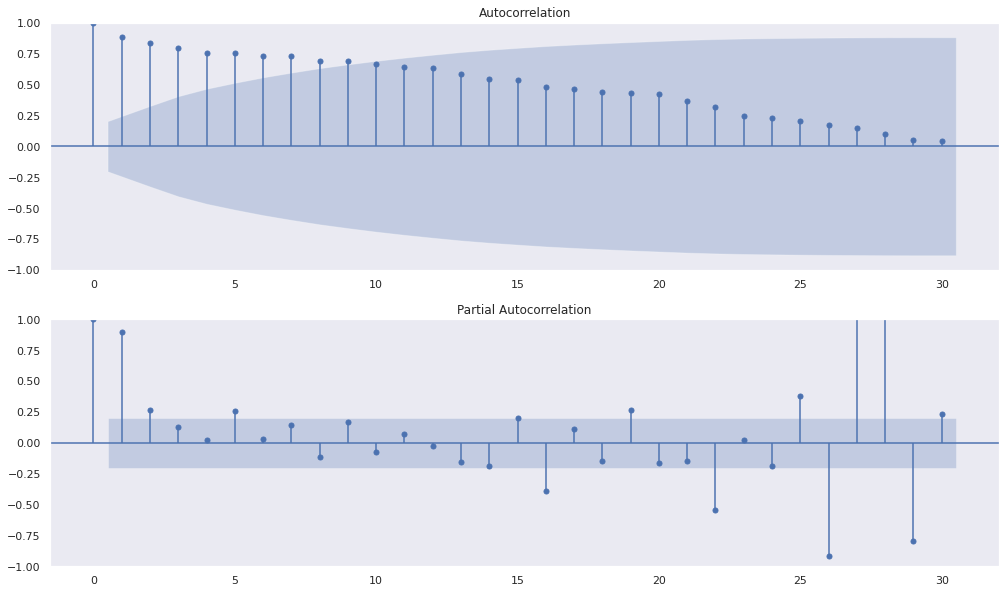

In [45]:
ACF_and_PACF(shows_added.value)

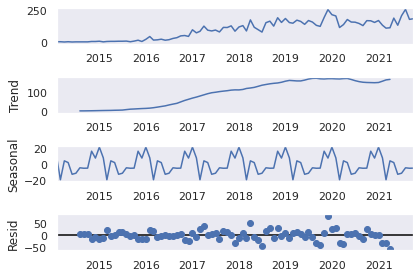

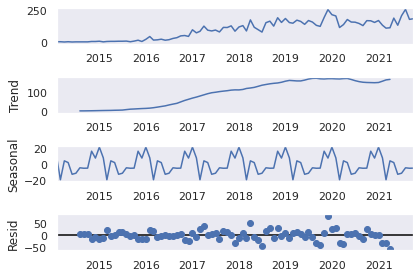

In [46]:
decomposition = sm.tsa.seasonal_decompose(shows_added,  model = "additive")
decomposition.plot()

In [47]:
from pandas.core import window
rolmean = shows_added.rolling(window = 12).mean()
rolstd = shows_added.rolling(window = 12).std()
rolmean

,value
date_added,
2014-01-31,NaN
2014-02-28,NaN
2014-03-31,NaN
2014-04-30,NaN
2014-05-31,NaN
...,...
2021-05-31,146.833333
2021-06-30,151.083333
2021-07-31,160.333333


In [48]:
rolstd

,value
date_added,
2014-01-31,NaN
2014-02-28,NaN
2014-03-31,NaN
2014-04-30,NaN
2014-05-31,NaN
...,...
2021-05-31,24.457136
2021-06-30,29.998359
2021-07-31,42.709023


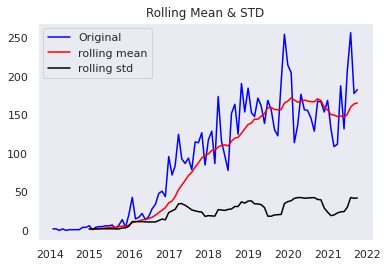

In [49]:
orig = plt.plot(shows_added , color = "blue" , label = "Original")
mean = plt.plot(rolmean , color = "red" , label = "rolling mean")
std = plt.plot(rolstd , color = "black" , label = "rolling std")
plt.legend(loc = "best")
plt.title ("Rolling Mean & STD")
plt.show()

In [50]:
print("Results of Dickey Fuller Test: ")
dftest = adfuller(shows_added, autolag= "AIC")

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test: 
Test Statistic                 -0.771501
p-value                         0.827350
#Lags Used                      8.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


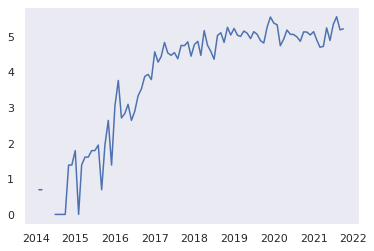

In [51]:
shows_added_logScale =np.log(shows_added)
plt.plot(shows_added_logScale)

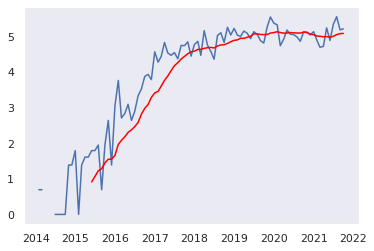

In [52]:
movingAverage = shows_added_logScale.rolling(window=12).mean()
movingSTD = shows_added_logScale.rolling(window=12).std()
plt.plot(shows_added_logScale)
plt.plot(movingAverage, color='red')

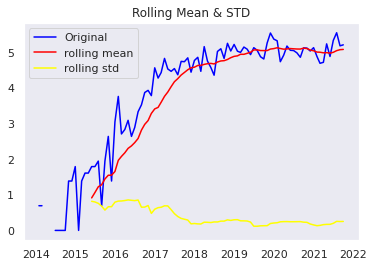

In [53]:
orig = plt.plot(shows_added_logScale , color = "blue" , label = "Original")
mean = plt.plot(shows_added_logScale.rolling(window=12).mean() , color = "red" , label = "rolling mean")
std = plt.plot(shows_added_logScale.rolling(window=12).std() , color = "yellow" , label = "rolling std")
plt.legend(loc = "best")
plt.title ("Rolling Mean & STD")
plt.show()

In [54]:
datasetLogScaleMinusMovingAverage = shows_added_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,value
date_added,
2015-05-31,0.878320
2015-06-30,0.729006
2015-07-31,0.720998
2015-08-31,-0.589527
2015-09-30,0.501076
2015-10-31,1.089827
2015-11-30,-0.162936
2015-12-31,1.390895
2016-01-31,1.794139


In [55]:
def test_stationarity(timeseries):
    
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

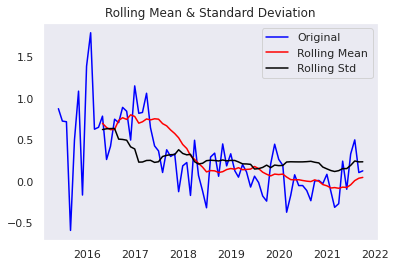

Results of Dickey Fuller Test:
Test Statistic                 -2.296104
p-value                         0.173227
#Lags Used                      2.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [56]:
test_stationarity(datasetLogScaleMinusMovingAverage)

In [57]:
from statsmodels.tsa.arima_model import ARIMA

In [58]:
data = datasetLogScaleMinusMovingAverage.dropna()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   77
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -32.256
Date:                Thu, 29 Sep 2022   AIC                             72.511
Time:                        14:10:34   BIC                             81.886
Sample:                    05-31-2015   HQIC                            76.261
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2965      0.111      2.680      0.007       0.080       0.513
ar.L1          0.4221      0.075      5.611      0.000       0.275       0.569
ar.L2          0.1698      0.084      2.022      0.0

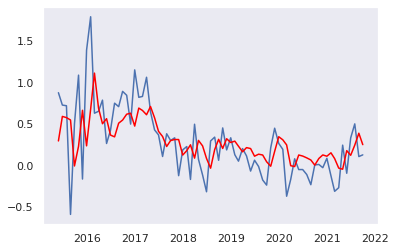

In [59]:
model =sm.tsa.ARIMA(data, order = (2,0,0))
res_ar = model.fit()
plt.plot(data)
plt.plot(res_ar.fittedvalues , color = "red")
print (res_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   77
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -27.962
Date:                Thu, 29 Sep 2022   AIC                             65.923
Time:                        14:10:36   BIC                             77.642
Sample:                    05-31-2015   HQIC                            70.611
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3212      0.216      1.489      0.137      -0.102       0.744
ar.L1          1.0704      0.152      7.048      0.000       0.773       1.368
ar.L2         -0.1038      0.118     -0.882      0.3

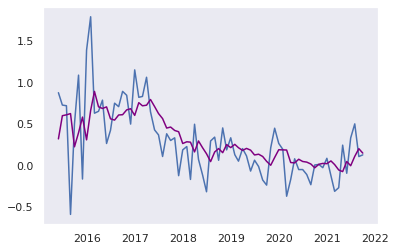

In [60]:
model = sm.tsa.ARIMA(data , order = (2,0,1))
res_ar = model.fit()
plt.plot(data)
plt.plot(res_ar.fittedvalues , color = "purple")
print (res_ar.summary())